## Using RNNs to classify sentiment on IMDB data

In this assignment,you will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.


Walk through the followinng steps to prepare the data and the building of an RNN model. 

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN,Dense, Activation, LSTM, Flatten, Dropout
from tensorflow.keras import initializers
from keras.optimizers import RMSprop


1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 30 words and the pick the 2000 most common words. 

In [2]:
(X_train,Y_train),(X_test,Y_test) = imdb.load_data(path='imdb.npz',
    num_words=2000,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)

3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [3]:
print("X train shape: ",X_train.shape)
print("X test shape: ",X_test.shape)

X train shape:  (25000,)
X test shape:  (25000,)


4- Pad (or truncate) the sequences so that they are of the maximum length

In [4]:
src_vocab_train = d2l.Vocab(X_train, min_freq=1,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
src_vocab_test = d2l.Vocab(X_test, min_freq=1,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])

len(src_vocab_train)

2002

In [5]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad

X_train_pad_test = truncate_pad(src_vocab_train[X_train[0]], 30, src_vocab_train['<pad>'] )
print(X_train[0])
print(X_train_pad_test)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
[33, 15, 23, 17, 45, 531, 973, 1623, 1386, 67, 460, 4, 68, 4, 5, 175, 38, 258, 6, 26, 102, 45, 840, 114, 

In [6]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len


In [7]:
X_train_30, val_len = build_array_nmt(X_train, src_vocab_train, 30)
X_test_30, val_len = build_array_nmt(X_test, src_vocab_test, 30)

5- After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [8]:
print("X train shape: ",X_train_30.shape)
print("X test shape: ",X_test_30.shape)

X train shape:  (25000, 30)
X test shape:  (25000, 30)


## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla) RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






6- Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [9]:
print(len(X_train_30[0]))

30


In [10]:
rnn = Sequential()
rnn.add(Embedding(2002, 50, input_length = 30))
rnn.add(SimpleRNN(5, input_shape = (2002, 30), return_sequences = False, activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))

print(rnn.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            100100    
                                                                 
 simple_rnn (SimpleRNN)      (None, 5)                 280       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 100,386
Trainable params: 100,386
Non-trainable params: 0
_________________________________________________________________
None


7- How many parameters have the embedding layer?

In [11]:
#The embedding layer has 100100 parameters,in length vocab training we can see there was 2002 words
#the expected number was 2000 however with the 2 extra words the parameters goes from 2000 x 50 to 2002 x 50.

8- Train the network with the RMSprop with learning rate of .0001 and epochs=10.

In [12]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [13]:
history = rnn.fit(X_train_30, Y_train, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 4s 2ms/step - loss: 0.6862 - accuracy: 0.5434 - val_loss: 0.6764 - val_accuracy: 0.5582
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6517 - accuracy: 0.6371 - val_loss: 0.6361 - val_accuracy: 0.6548
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6124 - accuracy: 0.6968 - val_loss: 0.6167 - val_accuracy: 0.6862
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5906 - accuracy: 0.7157 - val_loss: 0.6065 - val_accuracy: 0.6884
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5750 - accuracy: 0.7250 - val_loss: 0.5999 - val_accuracy: 0.6906
Epoch 6/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5627 - accuracy: 0.7307 - val_loss: 0.5984 - val_accuracy: 0.6880
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5516 - accuracy: 0.7362 - val_loss: 0.5913 - val_accuracy:

9- PLot the loss and accuracy metrics during the training and interpret the result.

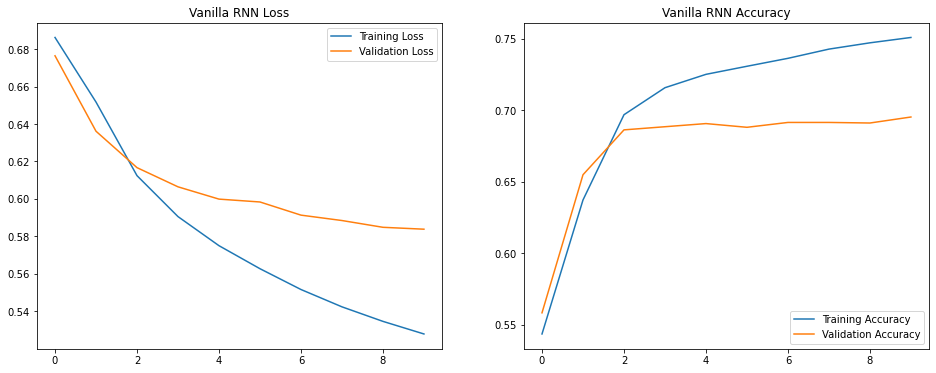

In [14]:
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')
    
plot_history(history,'Vanilla RNN')

10- Check the accuracy and the loss of your models on the test dataset.

In [15]:
test = rnn.evaluate(X_test_30,Y_test)


782/782 [==============================] - 1s 1ms/step - loss: 0.7963 - accuracy: 0.5060


## Tuning The Vanilla RNN Network


11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model.  Did it improve the performance?

12- Try different values of the  maximum length of a sequence ("max_features").  Can you improve the performance?

13- Try smaller and larger sizes of the RNN hidden dimension.  How does it affect the model performance?  How does it affect the run time?

In [16]:
#11) 80 words 
X_train_80, val_len = build_array_nmt(X_train, src_vocab_train, 80)
X_test_80, val_len = build_array_nmt(X_test, src_vocab_test, 80)
print("X train shape: ",X_train_80.shape)
print("X test shape: ",X_test_80.shape)


X train shape:  (25000, 80)
X test shape:  (25000, 80)


In [17]:
rnn = Sequential()
rnn.add(Embedding(2002, 50, input_length = 80))
rnn.add(SimpleRNN(5, input_shape = (2002, 80), return_sequences = False, activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [18]:
history = rnn.fit(X_train_80, Y_train, batch_size=16, epochs=10, validation_split=0.2)
test = rnn.evaluate(X_test_80,Y_test)
print(test)

Epoch 1/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6420 - accuracy: 0.6048 - val_loss: 0.5938 - val_accuracy: 0.7126
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5715 - accuracy: 0.7367 - val_loss: 0.5614 - val_accuracy: 0.7432
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5413 - accuracy: 0.7724 - val_loss: 0.5449 - val_accuracy: 0.7590
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5196 - accuracy: 0.7881 - val_loss: 0.5349 - val_accuracy: 0.7638
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5018 - accuracy: 0.7969 - val_loss: 0.5204 - val_accuracy: 0.7748
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4863 - accuracy: 0.8031 - val_loss: 0.5105 - val_accuracy: 0.7786
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4726 - accuracy: 0.8081 - val_loss: 0.5026 - val_accuracy:

In [19]:
#yes it slightly imporoved performance

In [20]:
#12) 10 words
X_train_10, val_len = build_array_nmt(X_train, src_vocab_train, 10)
X_test_10, val_len = build_array_nmt(X_test, src_vocab_test, 10)
print("X train shape: ",X_train_10.shape)
print("X test shape: ",X_test_10.shape)

X train shape:  (25000, 10)
X test shape:  (25000, 10)


In [21]:
rnn = Sequential()
rnn.add(Embedding(2002, 50, input_length = 10))
rnn.add(SimpleRNN(5, input_shape = (2002, 10), return_sequences = False, activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [22]:
history = rnn.fit(X_train_10, Y_train, batch_size=16, epochs=10, validation_data=(X_test_10, Y_test))
test = rnn.evaluate(X_test_10,Y_test)
print(test)
#looks like the improvements occured with a higher level of max length.

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6862 - accuracy: 0.5229 - val_loss: 0.6937 - val_accuracy: 0.5170
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6605 - accuracy: 0.5984 - val_loss: 0.7073 - val_accuracy: 0.5202
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6404 - accuracy: 0.6470 - val_loss: 0.7219 - val_accuracy: 0.5215
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6281 - accuracy: 0.6637 - val_loss: 0.7319 - val_accuracy: 0.5115
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6184 - accuracy: 0.6762 - val_loss: 0.7364 - val_accuracy: 0.5080
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6103 - accuracy: 0.6796 - val_loss: 0.7486 - val_accuracy: 0.5082
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6033 - accuracy: 0.6846 - val_loss: 0.7514 - val_accuracy:

In [23]:
#13) larger dim 
rnn = Sequential()
rnn.add(Embedding(2002, 100, input_length = 30))
rnn.add(SimpleRNN(25, input_shape = (2002, 30), return_sequences = False, activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

print(rnn.summary())
history = rnn.fit(X_train_30, Y_train, batch_size=16, epochs=10, validation_split=0.2)
test = rnn.evaluate(X_test_30,Y_test)
print(test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 100)           200200    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 25)                3150      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 203,376
Trainable params: 203,376
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6927 - accuracy: 0.5153 - val_loss: 0.6920 - val_accuracy: 0.5270
Epoch 2/10
1250/1250 [=========

In [24]:
# smaller dim
rnn = Sequential()
rnn.add(Embedding(2002, 10, input_length = 30))
rnn.add(SimpleRNN(3, input_shape = (2002, 30), return_sequences = False, activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

print(rnn.summary())
history = rnn.fit(X_train_30, Y_train, batch_size=16, epochs=10, validation_split=0.2)
test = rnn.evaluate(X_test_30,Y_test)
print(test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 10)            20020     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 3)                 42        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 20,066
Trainable params: 20,066
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 2/10
1250/1250 [===========

The larger hidden layers took longer run time, however the small dimension was actually more accurate suprisingly. 

## Train LSTM and GRU networks


14- Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

In [28]:
LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(2003, 50, input_length=30, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(LSTM.summary())
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
LSTM.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

history = LSTM.fit(X_train_30, Y_train, batch_size=16, epochs=10, validation_split=0.2)
test = LSTM.evaluate(X_test_30,Y_test)
print(test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 50)            100150    
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

LSTM has the highest accuracy score and had similar run times to the rnn model

In [29]:
GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(2002, 50, input_length=30),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])
print(GRU.summary())
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
GRU.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

history = GRU.fit(X_train_30, Y_train, batch_size=16, epochs=10, validation_split=0.2)
test = GRU.evaluate(X_test_30,Y_test)
print(test)
    


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 50)            100100    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              44544     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 24)                3096      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 147,765
Trainable params: 147,765
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1250/1250 [==============================] - 9s 6ms/step - loss: 0.6926 - accuracy: 0.5150 - val_l

The GRU model was a slower run time, however had a lower accuracy rate


Source for LSTM and GRU model https://www.kaggle.com/code/imdevskp/imdb-review-classification-lstm-gru-cnn-glove